<left>
    <img src="https://upload.wikimedia.org/wikipedia/commons/f/f3/Logo_SYGNET.png" width="90" alt="cognitiveclass.ai logo">
</left>

<center>
    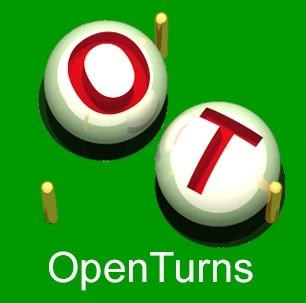
</center>




# A.I. Polynomial Chaos Expansion


Building the PCE Metamodel for a subsidence prediction hybrid approach with LSTM network.

## Objectives

By conducting this thorough data analysis, we'll gain a deeper understanding of the dataset and the underlying physical processes. This will not only help in building a better NN model but also provide valuable insights into the soil subsidence phenomenon in our simulation. These insights can guide feature selection, inform model architecture decisions, and improve interpretability of the NN's results.

*   Data Science with Python
*   Statistics

<h3>Table of Contents</h3>
<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ul>
        <li><a href="#1. Installing TensorFlow">1. Installing TensorFlow</a></li>
        <li><a href="#2. Importing Libraries">2. Importing Libraries</a></li>
        <li><a href="#3. Loading the AI_Dataset">3. Loading the AI_Dataset</a></li>
        <li><a href="#4. Tailoring 3 Datasets">4. Tailoring 3 Datasets</a></li>
        <li><a href="#5. Splitting the Data Samples">5. Splitting the Data Samples</a></li>
        <li><a href="#6. Polynomial Distribution">6. Polynomial Distribution</a></li>
        <li><a href="#7. Polynomial Basis">7. Polynomial Basis</a></li>
        <li><a href="#8. Residuals Interpolation for Matching with X_TRAIN">8. Residuals Interpolation for Matching with                      X_TRAIN</a></li>
        <li><a href="#9. Maximum Dimension and Adaptive Strategy">9. Maximum Dimension and Adaptive Strategy</a></li>
        <li><a href="#10. Checking Dimensions of Final Data">10. Checking Dimensions of Final Data</a></li>
        <li><a href="#11. Fit Polynomial Chaos Expansion (PCE) using OpenTURNS">11. Fit Polynomial Chaos Expansion (PCE)                      using OpenTURNS</a></li>
        <li><a href="#12. Calculate Mean-Squared Errors of LSTM">12. Calculate Mean-Squared Errors of LSTM</a></li>
    </ul>
</div>

<hr>

<h3>1. Installing OpenTURNS and other Modules</h3>

In [ ]:
# Install OpenMDAO
!pip install openmdao[all]
!pip install numpy==1.21.6
!pip install statsmodels
!pip install chaospy
!pip install openturns==1.23

<h3>2. Importing Libraries</h3>

In [4]:
import chaospy as cp
import openturns as ot
import openturns.viewer as viewer
import openmdao
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pylab as plt
import statsmodels.api as sm
import scipy
print(ot.__version__)

1.7.3


<h3>3. Loading the <i>LSTM Performance Records</i></h3>

Overall Test Loss

In [ ]:
from sklearn.preprocessing import RobustScaler

# Load the data from CSV
train_data = pd.read_csv('test_predictions.csv')

# Remove NaNs and infinity values
train_data.replace([np.inf, -np.inf], np.nan, inplace=True)
train_data.dropna(inplace=True)

# Remove outliers using IQR
Q1 = train_data['Test Predictions'].quantile(0.25)
Q3 = train_data['Test Predictions'].quantile(0.75)
IQR = Q3 - Q1
train_data = train_data[~((train_data['Test Predictions'] < (Q1 - 1.5 * IQR)) | (train_data['Test Predictions'] > (Q3 + 1.5 * IQR)))]

# Normalize and scale data
scaler = RobustScaler()
train_data['Test Predictions'] = scaler.fit_transform(train_data[['Test Predictions']])

print(train_data)

Validation Loss

In [ ]:
# Load the data from CSV
test_data = pd.read_csv('validation_predictions.csv')

# Remove NaNs and infinity values
test_data.replace([np.inf, -np.inf], np.nan, inplace=True)
test_data.dropna(inplace=True)

# Remove outliers using IQR
Q1 = test_data['Validation Predictions'].quantile(0.25)
Q3 = test_data['Validation Predictions'].quantile(0.75)
IQR = Q3 - Q1
test_data = test_data[~((test_data['Validation Predictions'] < (Q1 - 1.5 * IQR)) | (test_data['Validation Predictions'] > (Q3 + 1.5 * IQR)))]

# Normalize and scale data
scaler = RobustScaler()
test_data['Validation Predictions'] = scaler.fit_transform(test_data[['Validation Predictions']])

print(test_data)

Training Loss

In [ ]:
# Load the data from CSV
run_data = pd.read_csv('train_predictions.csv')

# Remove NaNs and infinity values
run_data.replace([np.inf, -np.inf], np.nan, inplace=True)
run_data.dropna(inplace=True)

# Remove outliers using IQR
Q1 = run_data['Train Predictions'].quantile(0.25)
Q3 = run_data['Train Predictions'].quantile(0.75)
IQR = Q3 - Q1
run_data = run_data[~((run_data['Train Predictions'] < (Q1 - 1.5 * IQR)) | (run_data['Train Predictions'] > (Q3 + 1.5 * IQR)))]

# Normalize and scale data
scaler = RobustScaler()
run_data['Train Predictions'] = scaler.fit_transform(run_data[['Train Predictions']])
run_data = run_data.sample(n=2304, random_state=42)
print(run_data)

run_array = run_data.values
#run_array = run_array[:2304]


print(run_array)

<h3>4. Loading Training Dataset</h3>

PIM Subsidence

In [ ]:
# Load only the 'PIM_Subsidence' column from CSV
pim_subsidence_data = pd.read_csv('PIM_Subsidence.csv', usecols=['PIM_Subsidence'])

# Remove NaNs and infinity values
pim_subsidence_data.replace([np.inf, -np.inf], np.nan, inplace=True)
pim_subsidence_data.dropna(inplace=True)

# Remove outliers using IQR
Q1 = pim_subsidence_data['PIM_Subsidence'].quantile(0.25)
Q3 = pim_subsidence_data['PIM_Subsidence'].quantile(0.75)
IQR = Q3 - Q1
pim_subsidence_data = pim_subsidence_data[~((pim_subsidence_data['PIM_Subsidence'] < (Q1 - 1.5 * IQR)) | (pim_subsidence_data['PIM_Subsidence'] > (Q3 + 1.5 * IQR)))]

# Normalize and scale data
scaler = RobustScaler()
pim_subsidence_data['PIM_Subsidence'] = scaler.fit_transform(pim_subsidence_data[['PIM_Subsidence']])

# Sample the data
pim_subsidence_data = pim_subsidence_data.sample(n=2304, random_state=42)

# Convert to NumPy array
pim_subsidence_array = pim_subsidence_data['PIM_Subsidence'].values

print(pim_subsidence_array)

In [ ]:
# Ensure PIM_Subsidence has 2304 elements
if pim_subsidence_array.shape[0] == 2304:
    # Reshape to a column vector
    pim_subsidence_array = pim_subsidence_array.reshape(-1, 1)
else:
    print("Error: PIM_Subsidence does not have 2304 elements.")

# Now PIM_Subsidence should have the same shape as Train Predictions
print(pim_subsidence_array.shape)  # Should output (2304, 1)
print(run_array.shape)  # Should output (2304, 1)

Cumulative-Displacement-Y

In [ ]:
# Load only the 'Cumulative-Displacement-Y' column from CSV
displacement_data = pd.read_csv('PIM_Subsidence.csv', usecols=['Cumulative-Displacement-Y'])

# Remove NaNs and infinity values
displacement_data.replace([np.inf, -np.inf], np.nan, inplace=True)
displacement_data.dropna(inplace=True)

# Remove outliers using IQR
Q1 = displacement_data['Cumulative-Displacement-Y'].quantile(0.25)
Q3 = displacement_data['Cumulative-Displacement-Y'].quantile(0.75)
IQR = Q3 - Q1
displacement_data = displacement_data[~((displacement_data['Cumulative-Displacement-Y'] < (Q1 - 1.5 * IQR)) | (displacement_data['Cumulative-Displacement-Y'] > (Q3 + 1.5 * IQR)))]

# Normalize and scale data
scaler = RobustScaler()
displacement_data['Cumulative-Displacement-Y'] = scaler.fit_transform(displacement_data[['Cumulative-Displacement-Y']])

# Sample the data
displacement_data = displacement_data.sample(n=2304, random_state=42)

# Convert to NumPy array
displacement_array = displacement_data['Cumulative-Displacement-Y'].values

print(displacement_array)

In [ ]:
# Ensure PIM_Subsidence has 2304 elements
if displacement_array.shape[0] == 2304:
    # Reshape to a column vector
    displacement_array = displacement_array.reshape(-1, 1)
else:
    print("Error: Cumulative Displacement does not have 2304 elements.")

# Now PIM_Subsidence should have the same shape as Train Predictions
print(displacement_array.shape)  # Should output (2304, 1)
print(run_array.shape)  # Should output (2304, 1)

Check for NaNs in Datasets

In [ ]:
# Check if there are any NaN values left
has_nans = train_data.isna().any().any()
print(f"Are there any NaNs left in the train data? {has_nans}")
has_nans = test_data.isna().any().any()
print(f"Are there any NaNs left in the test data? {has_nans}")
has_nans = run_data.isna().any().any()
print(f"Are there any NaNs left in the run data? {has_nans}")
has_nans = pim_subsidence_data.isna().any().any()
print(f"Are there any NaNs left in the run data? {has_nans}")
has_nans = displacement_data.isna().any().any()
print(f"Are there any NaNs left in the run data? {has_nans}")

<h3>5. Prepare Metamodel Samples</h3>

In [ ]:
#train_data = pd.concat([train_data, run_data], axis=1)
#test_data = pd.concat([test_data, run_data], axis=1)

# Convert the DataFrame to a numpy array (if necessary)
train_array = train_data.values
test_array = test_data.values

test_array = test_array[:2304]

train_array = np.concatenate([train_array, run_array], axis=1)
test_array = np.concatenate([test_array, run_array], axis=1)
dataset_array = np.concatenate([pim_subsidence_array, displacement_array], axis=1)

# Create an OpenTURNS Sample
inputSample = ot.Sample(train_array)

# For self-validation, use the same predictions as the output
outputSample = ot.Sample(dataset_array)

print(inputSample)
print(outputSample)

Save the Arrays

In [ ]:
# Assuming dataset_array
np.save('dataset_array.npy', dataset_array)  # Save dataset to a file
np.save('test_array.npy', test_array)  # Save dataset to a file
np.save('train_array.npy', train_array)  # Save dataset to a file

<h3>6. Metamodel Construction</h3>

In [ ]:
# Proceed with the PCE Metamodel construction
algo = ot.FunctionalChaosAlgorithm(inputSample, outputSample)
algo.run()
result = algo.getResult()
result
metamodel = result.getMetaModel()

In [ ]:
result

<h3>7. Metamodel Validation Plot 1</h3>

In [9]:
x1index = 0
x1value = 0.5
x2min = -3.0
x2max = 3.0
outputIndex = 1
metamodelParametric = ot.ParametricFunction(metamodel, [x1index], [x1value])
graph = metamodelParametric.getMarginal(outputIndex).draw(x2min, x2max)
graph.setLegends(["Metamodel"])
modelParametric = ot.ParametricFunction(metamodel, [x1index], [x1value])
curve = modelParametric.getMarginal(outputIndex).draw(x2min, x2max).getDrawable(0)
curve.setColor("red")
curve.setLegend("Model")
graph.add(curve)
graph.setLegendPosition("lower right")
graph.setXTitle("X2")
graph.setTitle("Metamodel Validation, output #%d" % (outputIndex))
view = viewer.View(graph)

<h3>8. Metamodel Validation</h3>

In [ ]:
# This must be change to take from LSTM dataset
dimension = 2
n_valid = 100
inputTest = inputSample[:n_valid]
outputTest = metamodel(inputTest)

# Perform the metamodel validation
val = ot.MetaModelValidation(inputSample, outputSample, metamodel)
# list all available methods for the MetaModelValidation object val
dir(val)

<h3>9. Compute R2</h3>

In [11]:
# Compute R2
R2 = val.computeR2Score()
print(f"R2 Score: {R2}")

Plot R2 Validation

In [ ]:
graph = val.drawValidation()
graph.setTitle("Metamodel validation R2=" + str(R2))
view = viewer.View(graph)

<h3>10. Check Mean Squared Error</h3>

In [ ]:
# Compute MSE
true_output = np.array(outputSample[:n_valid])  # True values for the test set
predicted_output = np.array(outputTest)         # Predicted values by the PCE metamodel

# Calculate MSE using numpy
mse = np.mean((true_output - predicted_output) ** 2)
print(f"Mean Squared Error: {mse}")

<h3>11. Sobol Indices</h3>

In [18]:
chaosSI = ot.FunctionalChaosSobolIndices(result)
chaosSI

<h3>12. Sensitivity Analysis</h3>

In [ ]:
sensitivityAnalysis = ot.FunctionalChaosSobolIndices(result)
first_order = [sensitivityAnalysis.getSobolIndex(i) for i in range(dimension)]
total_order = [sensitivityAnalysis.getSobolTotalIndex(i) for i in range(dimension)]
print("Sensitivity Analysis of the First Order Sobol Index is:", first_order)
print("Sensitivity Analysis of the Total Order Sobol Index is:", total_order)

<h3>13. Sobol' Index</h3>

In [ ]:
input_names = metamodel.getInputDescription()
graph = ot.SobolIndicesAlgorithm.DrawSobolIndices(input_names, first_order, total_order)
graph.setLegendPosition("center")
view = viewer.View(graph)

<h3>14. Maximum Total Degree</h3>

In [ ]:
ot.ResourceMap.GetAsUnsignedInteger("FunctionalChaosAlgorithm-MaximumTotalDegree")

Test the maximum degree

In [ ]:
degrees = range(1, 12)
r2 = ot.Sample(len(degrees), 1)  # Change to 1 if you have only one output

for maximumDegree in degrees:
    ot.ResourceMap.SetAsUnsignedInteger(
        "FunctionalChaosAlgorithm-MaximumTotalDegree", maximumDegree
    )
    print("Maximum total degree =", maximumDegree)
    algo = ot.FunctionalChaosAlgorithm(inputSample, outputSample)
    algo.run()
    result = algo.getResult()
    metamodel = result.getMetaModel()

    # Since there's only one output, remove the loop over outputIndex
    val = ot.MetaModelValidation(outputTest, metamodel(inputTest))
    r2Value = min(1.0, max(0.0, val.computeR2Score()[0]))  # Use [0] instead of [1]
    r2[maximumDegree - degrees[0], 0] = r2Value


<h3>15. Predictivity</h3>

In [ ]:
# Create the graph for R2 values for each output
graph = ot.Graph("Predictivity", "Total degree", "R2", True)

# Plot for output 0
cloud = ot.Cloud([[d] for d in degrees], r2[:, 0])
cloud.setLegend("Output #0")
cloud.setPointStyle("bullet")
graph.add(cloud)

# Check if there is a second output (if r2 has more than one column)
if r2.getDimension() > 1:
    cloud = ot.Cloud([[d] for d in degrees], r2[:, 1])
    cloud.setLegend("Output #1")
    cloud.setColor("red")
    cloud.setPointStyle("bullet")
    graph.add(cloud)

graph.setLegendPosition("upper right")
view = viewer.View(graph, legend_kw={"bbox_to_anchor": (1.0, 1.0), "loc": "upper left"})
plt.subplots_adjust(right=0.7)

plt.show()

<h3>15. Metamodel Visualisation with openMDAO</h3>

In [ ]:
import openmdao.api as om
import numpy as np
import matplotlib.pyplot as plt

# Assuming train_x0, train_x1, and t_data are correctly loaded
train_x0 = train_array[:, 0]  # First input dimension
train_x1 = train_array[:, 1]  # Second input dimension
t_data = test_array  # Replace with your dataset (PIM subsidence + displacement)

# Define the OpenMDAO Problem
prob = om.Problem()

# MetaModelUnStructuredComp for unstructured data
mm = prob.model.add_subsystem('mm', om.MetaModelUnStructuredComp(), promotes=['x0', 'x1'])

# Add inputs from your training data
mm.add_input('x0', 0.0, training_data=train_x0)
mm.add_input('x1', 0.0, training_data=train_x1)

# Add separate outputs for the two columns of your dataset
mm.add_output('f1', 0.0, training_data=t_data[:, 0])  # First output: Cumulative-Displacement-Y
mm.add_output('f2', 0.0, training_data=t_data[:, 1])  # Second output: PIM Subsidence

# Specify the surrogate model for both outputs using either of 2 options:
# NearestNeighbor - Surrogate model based on the N-Dimensional Interpolation
# ResponseSurface - Surrogate Model based on second order response surface equations
mm.options['default_surrogate'] = om.ResponseSurface()

# Set up and finalize the problem
prob.setup()
prob.final_setup()

# Now let's visualize the PCE metamodel predictions over the input space

# Create a meshgrid for visualizing the input space
x0_min, x0_max = min(train_x0), max(train_x0)
x1_min, x1_max = min(train_x1), max(train_x1)

x0_range = np.linspace(x0_min, x0_max, 100)
x1_range = np.linspace(x1_min, x1_max, 100)

X0, X1 = np.meshgrid(x0_range, x1_range)

# Initialize arrays to store the predictions
F1 = np.zeros_like(X0)
F2 = np.zeros_like(X0)

# Evaluate the PCE metamodel for each point in the meshgrid
for i in range(X0.shape[0]):
    for j in range(X0.shape[1]):
        prob['x0'] = X0[i, j]
        prob['x1'] = X1[i, j]
        prob.run_model()
        F1[i, j] = prob['mm.f1']
        F2[i, j] = prob['mm.f2']

Plot the Heatmaps

In [ ]:
# Plot the first output (Cumulative-Displacement-Y)
plt.contourf(X0, X1, F1, levels=50, cmap='viridis')
plt.colorbar()
plt.title('PCE Metamodel Prediction Surface (Validation Loss)')
plt.xlabel('Input Dimension x0')
plt.ylabel('Input Dimension x1')
plt.show()

# Plot the second output (PIM Subsidence)
plt.contourf(X0, X1, F2, levels=50, cmap='plasma')
plt.colorbar()
plt.title('PCE Metamodel Prediction Surface (Training Loss)')
plt.xlabel('Input Dimension x0')
plt.ylabel('Input Dimension x1')
plt.show()

<h3>16. FunctionalChaosResult Visualisation with openMDAO</h3>

In [ ]:
import openmdao.api as om
import numpy as np

# Define a custom surrogate class for the Functional Chaos Expansion (FCE)
class FCE_Surrogate(om.MetaModelUnStructuredComp):
    def setup(self):
        # FCE input data (you can replace this with actual data if needed)
        train_x0 = np.linspace(0, 1, 20)  # First input dimension (x0)
        train_x1 = np.linspace(0, 1, 20)  # Second input dimension (x1)

        # FCE output coefficients for f1 and f2 (replace with actual coefficients)
        train_f1 = [-0.3154594, 0.05878552, 1.508912, -0.1841002, -3.16418, 5.736576, -7.098539]  # Output 1 coefficients (f1)
        train_f2 = [0.2007267, -0.03381607, 0.07644821, 0.06483326, -0.2200801, 0.400791, -0.4640608]  # Output 2 coefficients (f2)

        # Method to evaluate Functional Chaos Expansion
        def evaluate_fce(coeffs, x0, x1):
            """Apply the FCE expansion to get the output at given x0, x1."""
            return (
                coeffs[0] + coeffs[1] * x0 + coeffs[2] * x1 +
                coeffs[3] * (x0 ** 2) + coeffs[4] * (x1 ** 2) +
                coeffs[5] * (x0 ** 3) + coeffs[6] * (x1 ** 3)
            )

        # Generate training data for outputs using the FCE coefficients
        t_data_f1 = evaluate_fce(train_f1, train_x0, train_x1)
        t_data_f2 = evaluate_fce(train_f2, train_x0, train_x1)

        # Add inputs
        self.add_input('x0', 0.0, training_data=train_x0)
        self.add_input('x1', 0.0, training_data=train_x1)

        # Add outputs with the training data derived from FCE
        self.add_output('f1', 0.0, training_data=t_data_f1)
        self.add_output('f2', 0.0, training_data=t_data_f2)

        # Specify the surrogate model (ResponseSurface or others)
        self.options['default_surrogate'] = om.ResponseSurface()

# Define the OpenMDAO problem and add the surrogate model
prob = om.Problem()
mm = prob.model.add_subsystem('mm', FCE_Surrogate(), promotes=['x0', 'x1'])

# Setup and finalize the problem
prob.setup()
prob.final_setup()

# Define the input ranges for visualization
x0_range = np.linspace(0, 1, 100)
x1_range = np.linspace(0, 1, 100)
X0, X1 = np.meshgrid(x0_range, x1_range)

# Evaluate the surrogate model for both outputs
F1 = np.zeros_like(X0)
F2 = np.zeros_like(X0)

for i in range(X0.shape[0]):
    for j in range(X0.shape[1]):
        prob['x0'] = X0[i, j]
        prob['x1'] = X1[i, j]
        prob.run_model()
        F1[i, j] = prob['mm.f1']
        F2[i, j] = prob['mm.f2']

# Visualize the results
import matplotlib.pyplot as plt

plt.contourf(X0, X1, F1, levels=50, cmap='viridis')
plt.colorbar()
plt.title('Metamodel Coefficient #0')
plt.xlabel('Input Dimension x0')
plt.ylabel('Input Dimension x1')
plt.show()

# Visualization of F2 (PIM Subsidence)
plt.contourf(X0, X1, F2, levels=50, cmap='plasma')
plt.colorbar()
plt.title('Metamodel Coefficient #1')
plt.xlabel('Input Dimension x0')
plt.ylabel('Input Dimension x1')
plt.show()

Optionally, open metamodels in external openMDAO viewer

In [ ]:
!openmdao view_mm /content/unstructured_meta_model_example.py

<h3>17. Sensitivity Analysis details table</h3>

Display results in a DataFrame table

In [ ]:
# Data for Combination 1
combination_1 = {
    'Input': ['test_predictions.csv + train_predictions.csv'],
    'Output': ['validation_predictions.csv + train_predictions.csv'],
    'R² Score': [[0.0143, 1]],
    'Relative Errors': [[0.9853, 2.743e-30]],
    'Residuals': [[0.0152, 2.552e-17]]
}

# Data for Combination 2
combination_2 = {
    'Input': ['test_predictions.csv + train_predictions.csv'],
    'Output': ['Cumulative-Displacement-Y + PIM_Subsidence'],
    'R² Score': [[0.0082, 0.0102]],
    'Relative Errors': [[0.9914, 0.9894]],
    'Residuals': [[0.1048, 0.0165]]
}

# Create DataFrames
df_combination_1 = pd.DataFrame(combination_1)
df_combination_2 = pd.DataFrame(combination_2)

# Display the tables
print("Combination 1:")
print(df_combination_1.to_string(index=False))

print("\nCombination 2:")
print(df_combination_2.to_string(index=False))